# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import RFE
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.zip', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [6]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: float(x.replace(' ', '').replace(',', '.').replace('$', '')) if [x] != [np.nan] else x)

In [8]:
print(f' Среднее значение по преобразованному в корректный вид признаку balance: {round(df.balance.describe()[1], 3)}')

 Среднее значение по преобразованному в корректный вид признаку balance: 1529.129


### Задание 4

In [9]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [10]:
# Количество пропусков после обработки
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [11]:
print(f' Среднее значение после обработки пропусков по  признаку balance: {round(df.balance.describe()[1], 3)}')

 Среднее значение после обработки пропусков по  признаку balance: 1526.936


### Задание 5

In [12]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df.job.mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df.education.mode()[0] if x == 'unknown' else x)

In [13]:
mask =df[(df['job'] == df.job.mode()[0]) & (df['education'] == df.education.mode()[0])]
print (f'Средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования {round(mask.balance.mean(), 3)}')

Средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования 1598.883


### Задание 6

In [14]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned_df, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned_df.shape[0]}')
print(f'Нижняя граница выбросов по методу Тьюки: {lower_bound}')
print(f'Верхняя граница выбросов по методу Тьюки: {upper_bound}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Нижняя граница выбросов по методу Тьюки: -2241.0
Верхняя граница выбросов по методу Тьюки: 4063.0


## Часть 2:  Разведывательный анализ

### Задание 1

Text(0.5, 1.0, 'Распределение количества клиентов банка имеющие/неимеющие депозит')

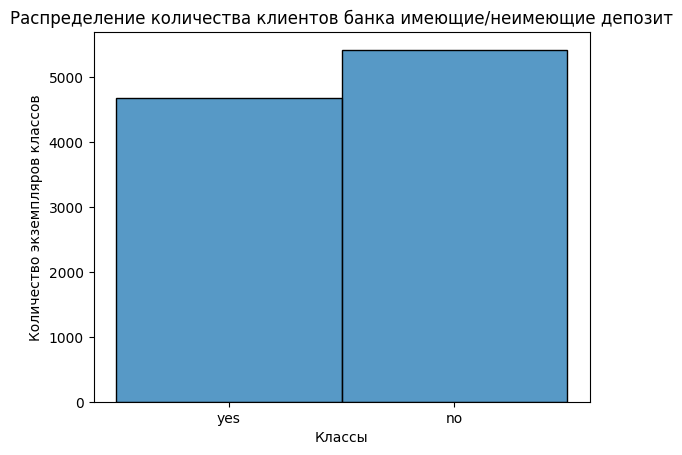

In [15]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
ax = sns.histplot(cleaned_df['deposit'])
ax.set(xlabel='Классы', ylabel='Количество экземпляров классов')
ax.set_title('Распределение количества клиентов банка имеющие/неимеющие депозит')

In [16]:
cleaned_df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

### Задания 2 и 3

In [17]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
numerical_type = [col for col in cleaned_df.columns if cleaned_df[col].dtypes != 'object']
cleaned_df[numerical_type].describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [18]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
object_type = [col for col in cleaned_df.columns if cleaned_df[col].dtypes == 'object']
cleaned_df[object_type].describe()
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


<Axes: xlabel='poutcome', ylabel='Count'>

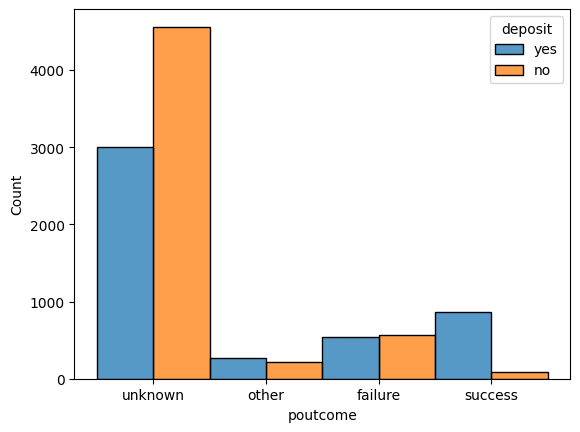

In [19]:
sns.histplot(data=cleaned_df, x='poutcome', hue='deposit', multiple='dodge')

In [20]:
cleaned_df.groupby(['poutcome'])['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: count, dtype: int64

### Задание 6

<Axes: xlabel='poutcome'>

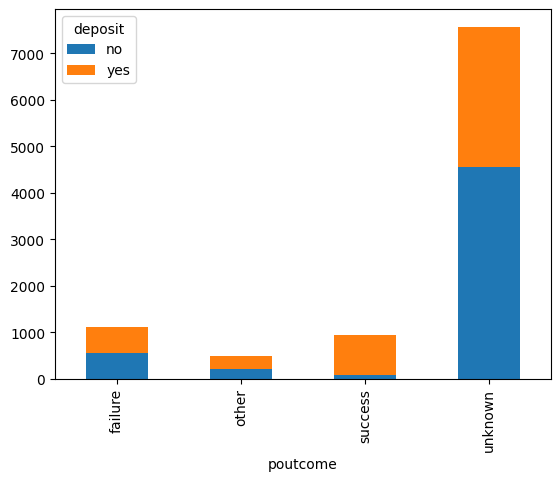

In [21]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
types = cleaned_df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 7

<Axes: xlabel='month', ylabel='Count'>

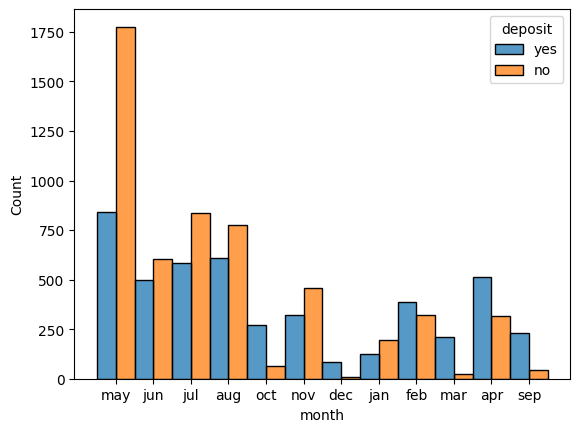

In [22]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
sns.histplot(data=cleaned_df, x='month', hue='deposit', multiple='dodge')

### Задание 8

<Axes: xlabel='age_group', ylabel='count'>

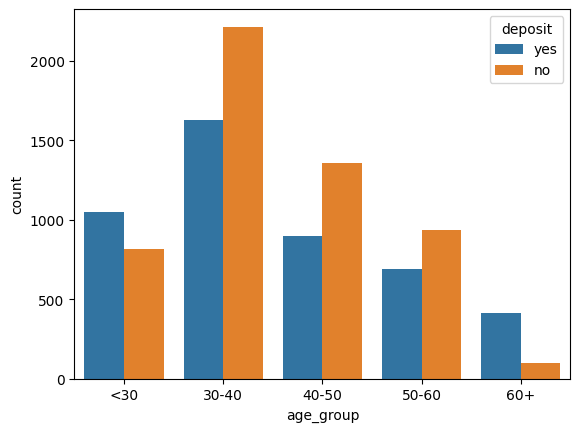

In [23]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned_df['age_group'] = pd.cut(cleaned_df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=cleaned_df)

### Задания 9 и 10

<Axes: xlabel='count', ylabel='marital'>

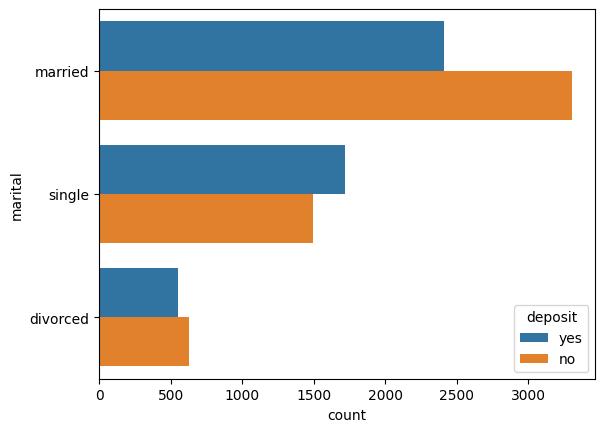

In [24]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(y='marital', hue='deposit', data=cleaned_df)

<Axes: xlabel='count', ylabel='education'>

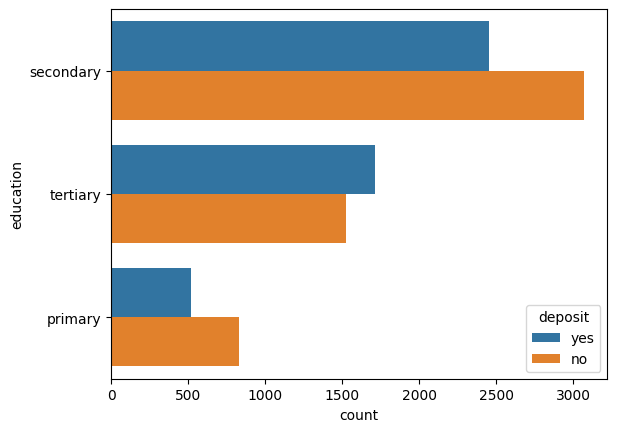

In [25]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(y='education', hue='deposit', data=cleaned_df)

<Axes: xlabel='count', ylabel='job'>

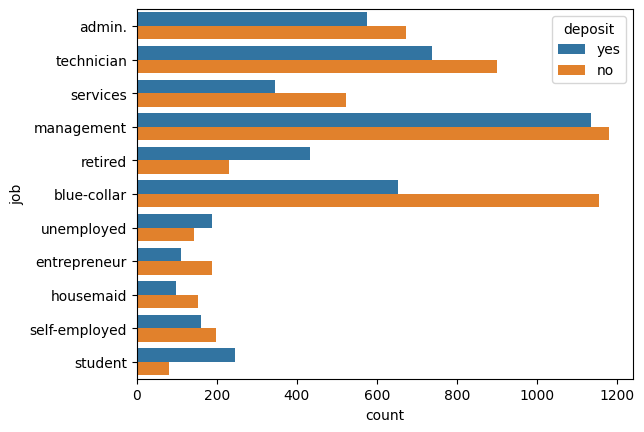

In [26]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(y='job', hue='deposit', data=cleaned_df)

### Задание 11

In [27]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
deposit_y = cleaned_df[cleaned_df['deposit'] == 'yes']
deposit_n = cleaned_df[cleaned_df['deposit'] == 'no']

In [28]:
y = deposit_y.groupby(['education', 'marital'])['marital'].count().unstack()

In [29]:
n = deposit_n.groupby(['education', 'marital'])['marital'].count().unstack()

<Axes: xlabel='marital', ylabel='education'>

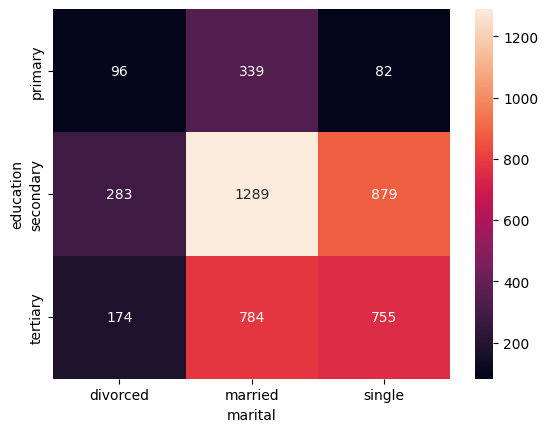

In [30]:
sns.heatmap(y, annot=True, fmt=".0f")

<Axes: xlabel='marital', ylabel='education'>

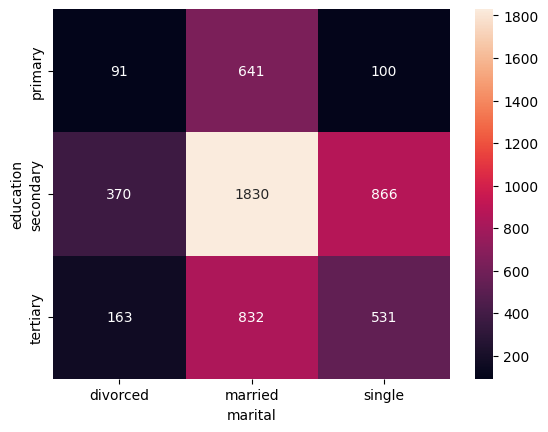

In [31]:
sns.heatmap(n, annot=True, fmt=".0f")

## Часть 3: преобразование данных

### Задание 1

In [32]:
# преобразуйте уровни образования
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
cleaned_df['education'] = lab_enc.fit_transform(cleaned_df['education'])
cleaned_df['age_group'] = lab_enc.fit_transform(cleaned_df['age_group'])
cleaned_df['education'].sum()

11995

### Задания 2 и 3

In [33]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned_df['deposit'] = cleaned_df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

cleaned_df['housing'] = cleaned_df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned_df['default'] = cleaned_df['default'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned_df['loan'] = cleaned_df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

cleaned_df.drop('age', axis= 1 , inplace= True ) 


In [34]:
cleaned_df.head()

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


In [35]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   job        10105 non-null  object 
 1   marital    10105 non-null  object 
 2   education  10105 non-null  int32  
 3   default    10105 non-null  int64  
 4   balance    10105 non-null  float64
 5   housing    10105 non-null  int64  
 6   loan       10105 non-null  int64  
 7   contact    10105 non-null  object 
 8   day        10105 non-null  int64  
 9   month      10105 non-null  object 
 10  duration   10105 non-null  int64  
 11  campaign   10105 non-null  int64  
 12  pdays      10105 non-null  int64  
 13  previous   10105 non-null  int64  
 14  poutcome   10105 non-null  object 
 15  deposit    10105 non-null  int64  
 16  age_group  10105 non-null  int32  
dtypes: float64(1), int32(2), int64(9), object(5)
memory usage: 1.3+ MB


### Задание 4

In [36]:
# создайте дамми-переменные
object_col = [col for col in cleaned_df.columns if cleaned_df[col].dtypes == 'object']
df_dummies = pd.get_dummies(cleaned_df, columns=object_col)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   education          10105 non-null  int32  
 1   default            10105 non-null  int64  
 2   balance            10105 non-null  float64
 3   housing            10105 non-null  int64  
 4   loan               10105 non-null  int64  
 5   day                10105 non-null  int64  
 6   duration           10105 non-null  int64  
 7   campaign           10105 non-null  int64  
 8   pdays              10105 non-null  int64  
 9   previous           10105 non-null  int64  
 10  deposit            10105 non-null  int64  
 11  age_group          10105 non-null  int32  
 12  job_admin.         10105 non-null  bool   
 13  job_blue-collar    10105 non-null  bool   
 14  job_entrepreneur   10105 non-null  bool   
 15  job_housemaid      10105 non-null  bool   
 16  job_management     10105 no

### Задания 5 и 6

<Axes: >

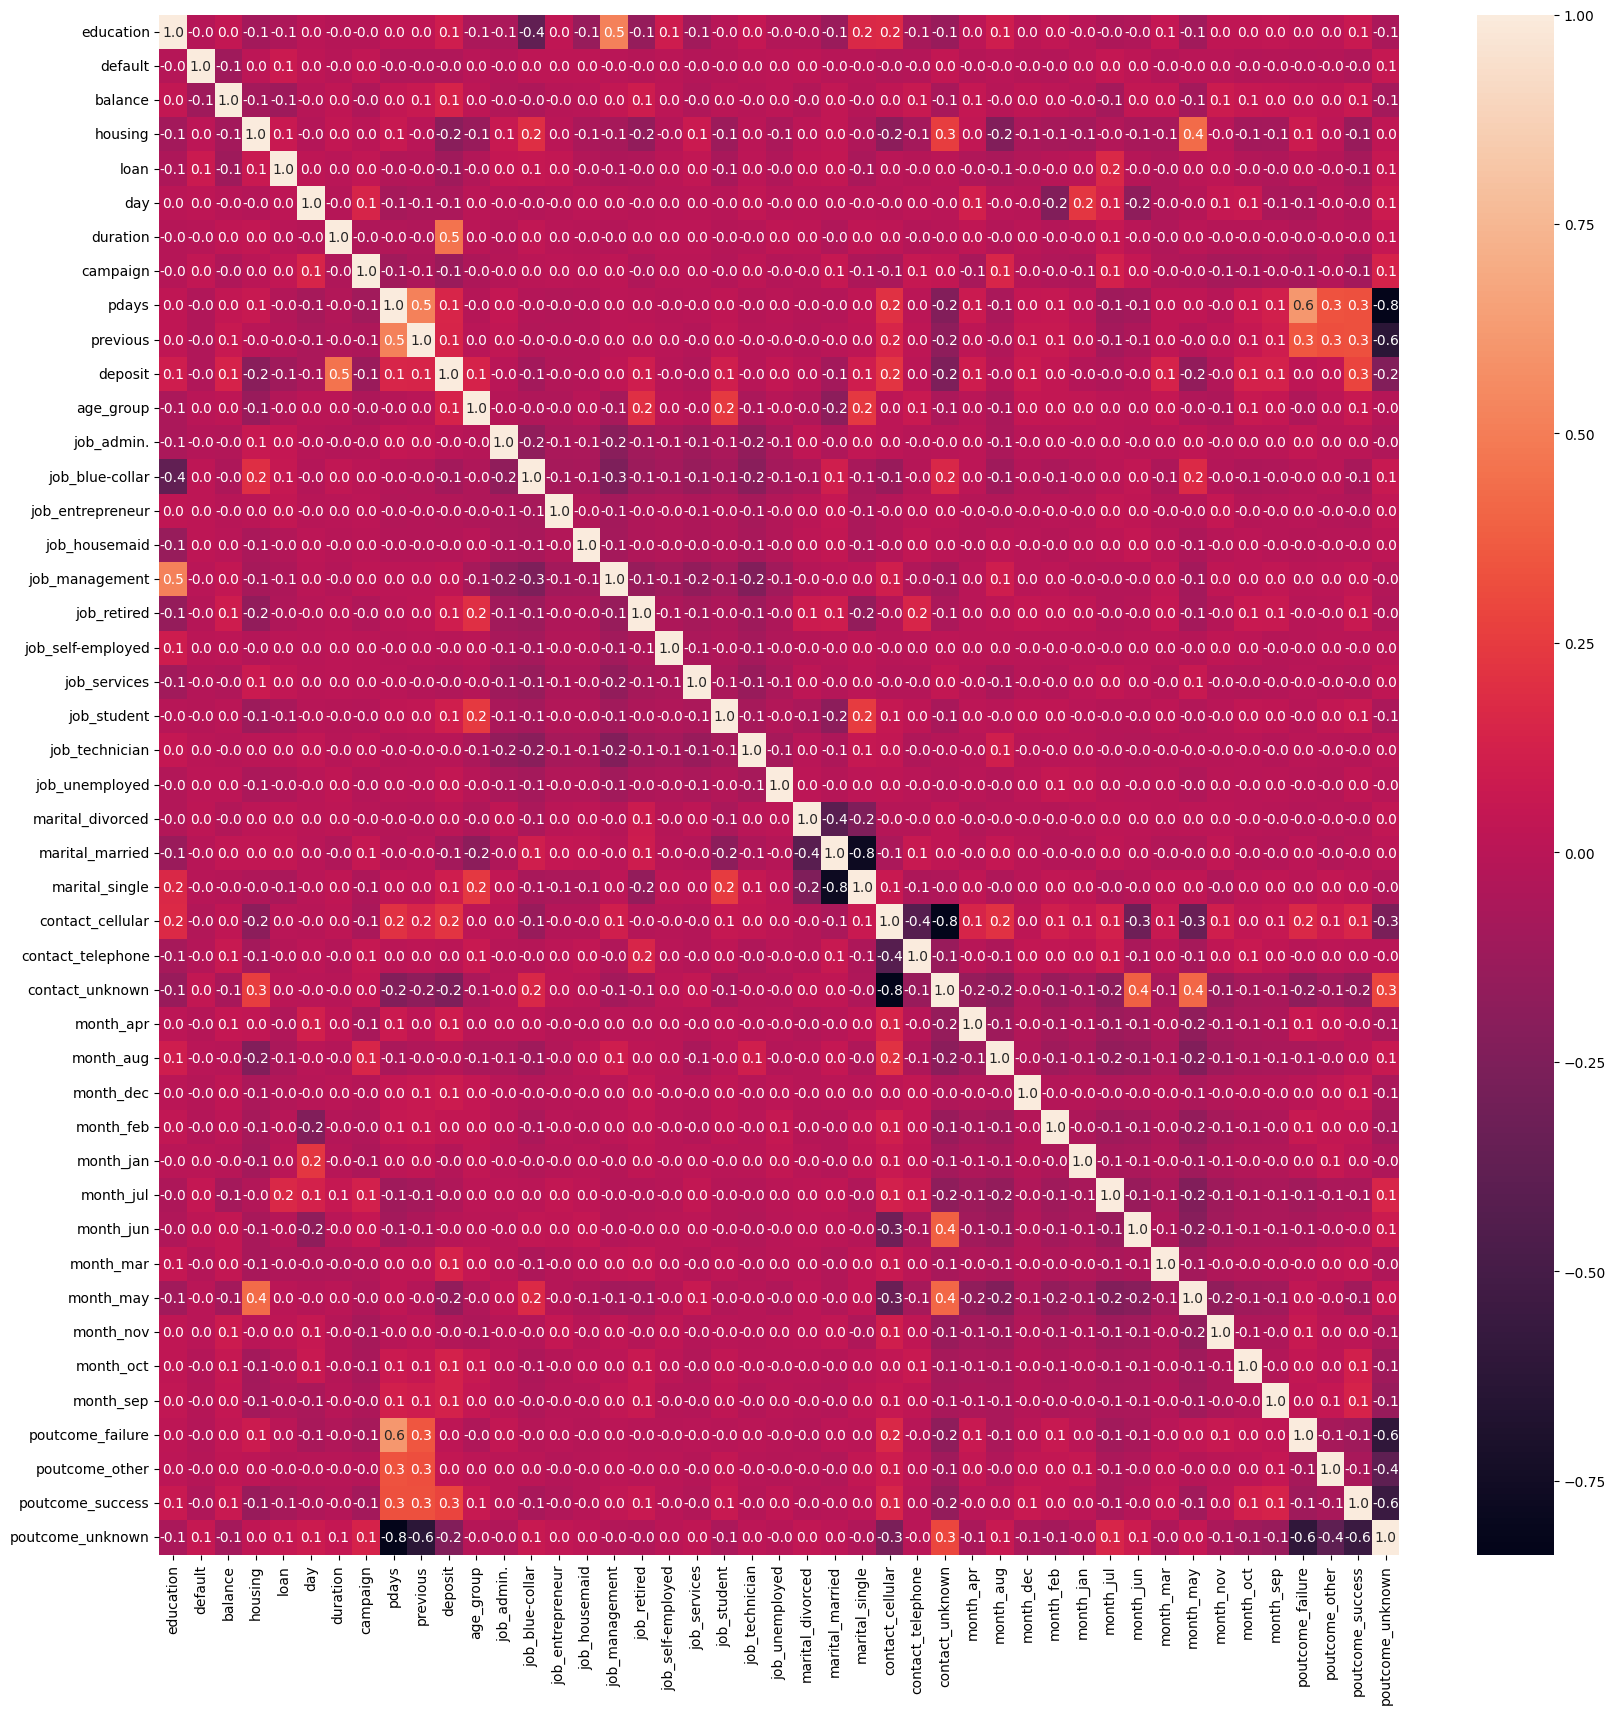

In [37]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

fig = plt.figure(figsize=(20, 20))
sns.heatmap(df_dummies.corr(), annot=True, fmt='.1f')

### Задания 7 и 8

In [38]:
X = df_dummies.drop(['deposit'], axis=1)
y = df_dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [39]:
# рассчитайте необходимые показатели
y_test.mean()

0.46326836581709147

### Задание 9

In [40]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
 
cols = selector.get_feature_names_out()
print(cols)

['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [41]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[cols])                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train[cols])    # fransform() на train данных
X_test_scaled = scaler.transform(X_test[cols])      # fransform() на test данных

print(X_test_scaled[:, 0].mean())

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [42]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000, random_state=42)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

y_train_pred = log_reg.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [43]:
# обучите решающие деревья, настройте максимальную глубину
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42, 
                                 criterion='entropy', 
                                 max_depth=8)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = dt.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3634
           1       0.82      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [44]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_leaf': [2, 5, 7, 10],
              'max_depth': [3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train)
y_train_pred = grid_search_tree.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred))) 

y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 453 ms
Wall time: 5.05 s
f1_score на обучающем наборе: 0.82
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_leaf': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [45]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42,
                                     n_estimators = 100,
                                     criterion = 'gini',
                                     min_samples_leaf = 5,
                                     max_depth = 10)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

print('f1_score на тестовом наборе: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

f1_score на тестовом наборе: 0.8166


### Задания 2 и 3

In [46]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_train_pred = gb.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

print('f1_score на тестовом наборе: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

f1_score на тестовом наборе: 0.8161


### Задание 4

In [47]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

y_test_pred = stack.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print(metrics.precision_score(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

0.8099547511312217


### Задание 5

In [48]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cols)

# Выделим три наиболее значимых признака
estimator = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)
 
selector.get_feature_names_out()

array(['balance', 'duration', 'poutcome_success'], dtype=object)

In [49]:
X_train_scaled.columns

Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [50]:
selector.ranking_

array([ 1,  4,  1,  8,  3, 11,  5, 12,  2,  6,  9,  7, 10,  1, 13])

### Задания 6,7,8

In [51]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [52]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-01-14 11:02:01,044] A new study created in memory with name: RandomForestClassifier


[I 2024-01-14 11:02:02,534] Trial 0 finished with value: 0.85142320925868 and parameters: {'n_estimators': 149, 'max_depth': 25, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.85142320925868.
[I 2024-01-14 11:02:04,092] Trial 1 finished with value: 0.8632867681682624 and parameters: {'n_estimators': 144, 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8632867681682624.
[I 2024-01-14 11:02:05,627] Trial 2 finished with value: 0.858880399189147 and parameters: {'n_estimators': 155, 'max_depth': 22, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8632867681682624.
[I 2024-01-14 11:02:06,787] Trial 3 finished with value: 0.859527559055118 and parameters: {'n_estimators': 120, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8632867681682624.
[I 2024-01-14 11:02:08,205] Trial 4 finished with value: 0.8509442796940846 and parameters: {'n_estimators': 145, 'max_depth': 19, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.863286768

CPU times: total: 36.3 s
Wall time: 36.9 s


In [53]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.4f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('accuracy_score на тестовом наборе: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.9239
f1_score на тестовом наборе: 0.8172
accuracy_score на тестовом наборе: 0.8264
